In [1]:
# Cell 1: Setup and Generate Time Series Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("PATIENT FLOW FORECASTING")
print("="*70)

# Load original data to get admission patterns
X = pd.read_csv(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\data\processed\features.csv')

print(f"✓ Data loaded: {len(X):,} admissions")

# Generate realistic time series data
# Simulate 3 years of daily admissions (2021-2023)
np.random.seed(42)

start_date = pd.Timestamp('2021-01-01')
end_date = pd.Timestamp('2023-12-31')
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

print(f"\nGenerating time series: {len(date_range)} days")
print(f"  From: {start_date.date()}")
print(f"  To: {end_date.date()}")

PATIENT FLOW FORECASTING
✓ Data loaded: 101,766 admissions

Generating time series: 1095 days
  From: 2021-01-01
  To: 2023-12-31


In [2]:
# Cell 2: Simulate Realistic Hospital Admission Patterns
print("SIMULATING REALISTIC ADMISSION PATTERNS")
print("="*70)

def generate_daily_admissions(date_range):
    """
    Generate realistic hospital admission patterns with:
    - Weekly seasonality (more on weekdays)
    - Annual seasonality (more in winter)
    - Trend (slight increase over time)
    - Random noise
    """
    admissions = []
    
    for i, date in enumerate(date_range):
        # Base rate: ~95 admissions per day (to match our 101k records over 3 years)
        base = 95
        
        # Trend: slight increase over time (1% per year)
        trend = base * (i / len(date_range)) * 0.03
        
        # Weekly seasonality: lower on weekends
        day_of_week = date.dayofweek
        if day_of_week in [5, 6]:  # Saturday, Sunday
            weekly_factor = 0.85
        else:
            weekly_factor = 1.05
        
        # Annual seasonality: higher in winter (flu season)
        month = date.month
        if month in [12, 1, 2]:  # Winter
            seasonal_factor = 1.15
        elif month in [6, 7, 8]:  # Summer
            seasonal_factor = 0.95
        else:
            seasonal_factor = 1.0
        
        # Random noise
        noise = np.random.normal(0, 5)
        
        # Calculate daily admissions
        daily_admissions = base + trend + (base * (weekly_factor - 1)) + (base * (seasonal_factor - 1)) + noise
        daily_admissions = max(50, int(daily_admissions))  # Minimum 50 per day
        
        admissions.append({
            'date': date,
            'admissions': daily_admissions,
            'day_of_week': date.day_name(),
            'month': date.month_name(),
            'year': date.year
        })
    
    return pd.DataFrame(admissions)

# Generate data
admissions_df = generate_daily_admissions(date_range)

print("✓ Time series data generated!")
print(f"\nDaily Admissions Statistics:")
print(f"  Mean: {admissions_df['admissions'].mean():.1f} patients/day")
print(f"  Min: {admissions_df['admissions'].min()} patients/day")
print(f"  Max: {admissions_df['admissions'].max()} patients/day")
print(f"  Total over 3 years: {admissions_df['admissions'].sum():,} admissions")

# Save time series data
admissions_df.to_csv(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\data\processed\daily_admissions.csv', 
                     index=False)
print("\n✓ Saved to data/processed/daily_admissions.csv")

SIMULATING REALISTIC ADMISSION PATTERNS
✓ Time series data generated!

Daily Admissions Statistics:
  Mean: 97.7 patients/day
  Min: 66 patients/day
  Max: 129 patients/day
  Total over 3 years: 107,000 admissions

✓ Saved to data/processed/daily_admissions.csv


VISUALIZING ADMISSION PATTERNS


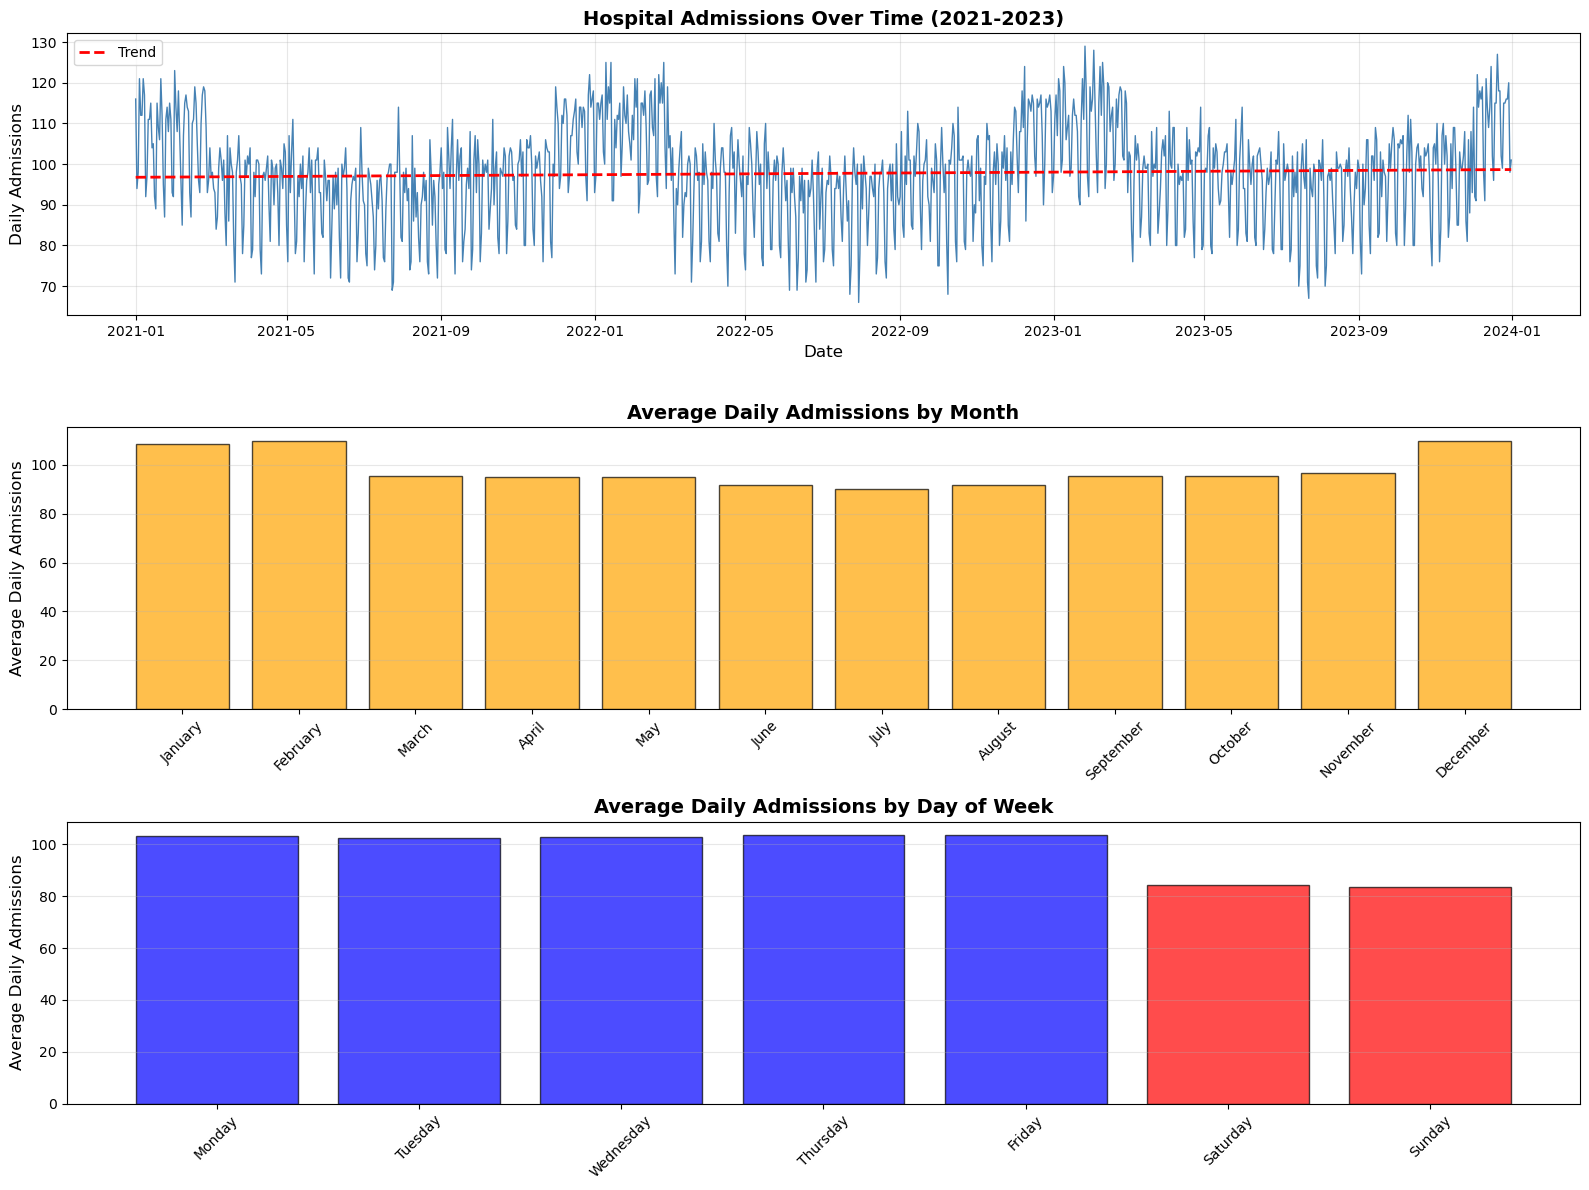

✓ Visualizations complete!


In [3]:
# Cell 3: Visualize Time Series Patterns
print("VISUALIZING ADMISSION PATTERNS")
print("="*70)

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# 1. Full time series
axes[0].plot(admissions_df['date'], admissions_df['admissions'], linewidth=1, color='steelblue')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Daily Admissions', fontsize=12)
axes[0].set_title('Hospital Admissions Over Time (2021-2023)', fontweight='bold', fontsize=14)
axes[0].grid(alpha=0.3)

# Add trend line
z = np.polyfit(range(len(admissions_df)), admissions_df['admissions'], 1)
p = np.poly1d(z)
axes[0].plot(admissions_df['date'], p(range(len(admissions_df))), 
             "r--", linewidth=2, label='Trend')
axes[0].legend()

# 2. Monthly average pattern
monthly_avg = admissions_df.groupby('month')['admissions'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])
axes[1].bar(range(12), monthly_avg.values, color='orange', alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(12))
axes[1].set_xticklabels(monthly_avg.index, rotation=45)
axes[1].set_ylabel('Average Daily Admissions', fontsize=12)
axes[1].set_title('Average Daily Admissions by Month', fontweight='bold', fontsize=14)
axes[1].grid(axis='y', alpha=0.3)

# 3. Weekly pattern
weekly_avg = admissions_df.groupby('day_of_week')['admissions'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
colors = ['blue']*5 + ['red']*2  # Weekdays blue, weekends red
axes[2].bar(range(7), weekly_avg.values, color=colors, alpha=0.7, edgecolor='black')
axes[2].set_xticks(range(7))
axes[2].set_xticklabels(weekly_avg.index, rotation=45)
axes[2].set_ylabel('Average Daily Admissions', fontsize=12)
axes[2].set_title('Average Daily Admissions by Day of Week', fontweight='bold', fontsize=14)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\results\admission_patterns.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualizations complete!")

PREPARING DATA FOR FORECASTING
Training data: 876 days (2021-01-01 to 2023-05-26)
Test data: 219 days (2023-05-27 to 2023-12-31)


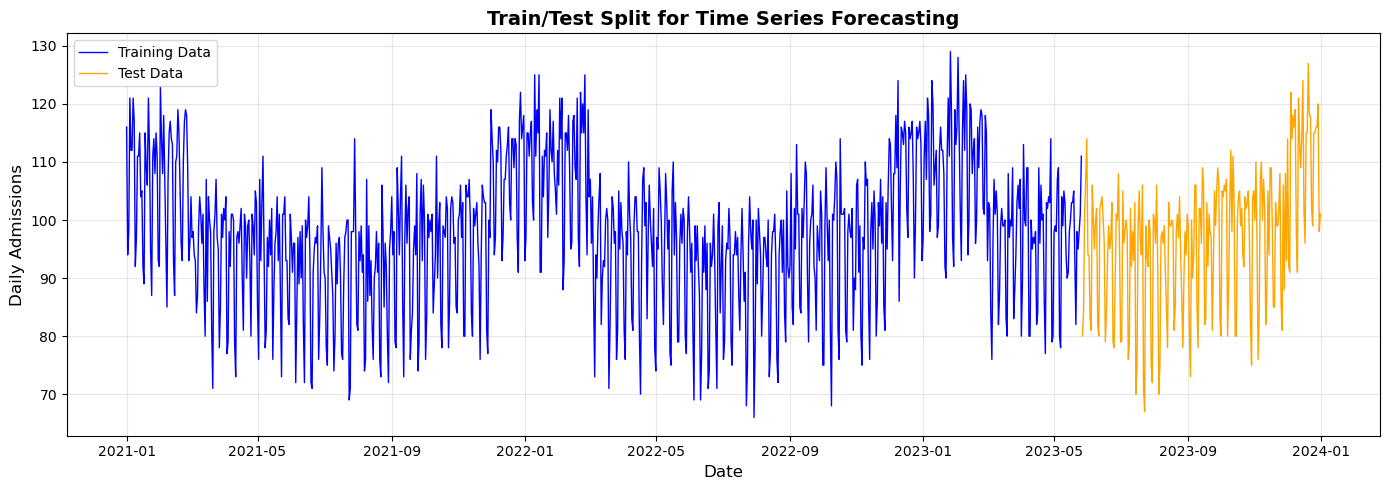

In [4]:
# Cell 4: Prepare Data for Time Series Forecasting
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error

print("PREPARING DATA FOR FORECASTING")
print("="*70)

# Set date as index
admissions_df['date'] = pd.to_datetime(admissions_df['date'])
admissions_df = admissions_df.set_index('date')

# Create train/test split (80/20) - MUST be chronological for time series!
train_size = int(len(admissions_df) * 0.8)
train_data = admissions_df[:train_size]
test_data = admissions_df[train_size:]

print(f"Training data: {len(train_data)} days ({train_data.index[0].date()} to {train_data.index[-1].date()})")
print(f"Test data: {len(test_data)} days ({test_data.index[0].date()} to {test_data.index[-1].date()})")

# Visualize split
plt.figure(figsize=(14, 5))
plt.plot(train_data.index, train_data['admissions'], label='Training Data', color='blue', linewidth=1)
plt.plot(test_data.index, test_data['admissions'], label='Test Data', color='orange', linewidth=1)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Admissions', fontsize=12)
plt.title('Train/Test Split for Time Series Forecasting', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

PREPARING DATA FOR FORECASTING
Training data: 876 days (2021-01-01 to 2023-05-26)
Test data: 219 days (2023-05-27 to 2023-12-31)


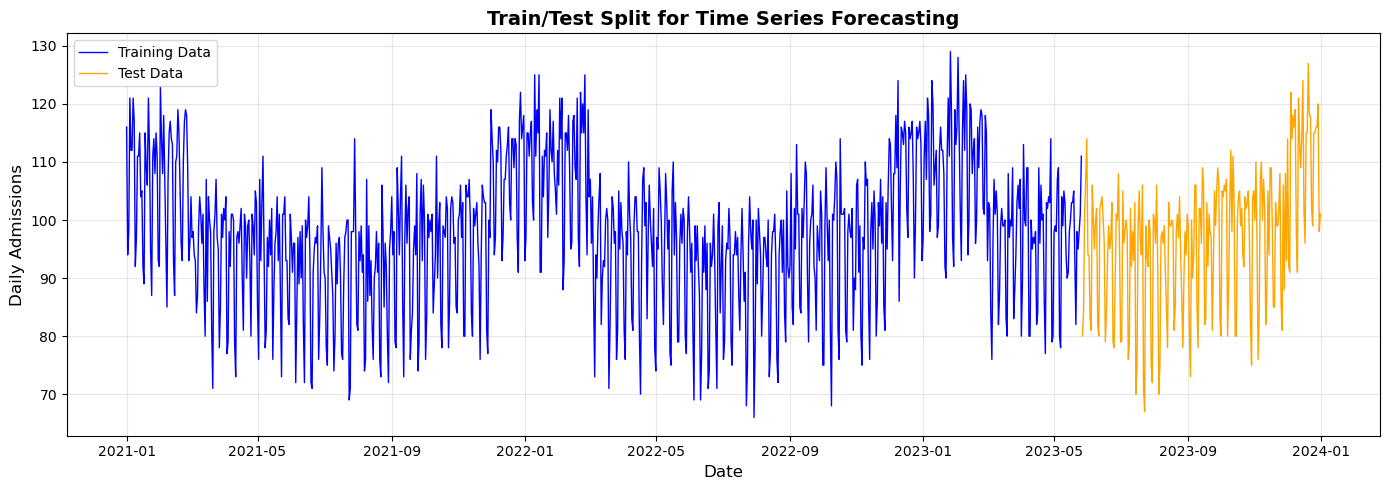

In [7]:
# Cell 4: Prepare Data for Time Series Forecasting (CORRECTED)
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

print("PREPARING DATA FOR FORECASTING")
print("="*70)

# Reload fresh data
admissions_df = pd.read_csv(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\data\processed\daily_admissions.csv')

# Set date as index
admissions_df['date'] = pd.to_datetime(admissions_df['date'])
admissions_df = admissions_df.set_index('date')

# Create train/test split (80/20) - MUST be chronological for time series!
train_size = int(len(admissions_df) * 0.8)
train_data = admissions_df[:train_size].copy()
test_data = admissions_df[train_size:].copy()

print(f"Training data: {len(train_data)} days ({train_data.index[0].date()} to {train_data.index[-1].date()})")
print(f"Test data: {len(test_data)} days ({test_data.index[0].date()} to {test_data.index[-1].date()})")

# Visualize split
plt.figure(figsize=(14, 5))
plt.plot(train_data.index, train_data['admissions'], label='Training Data', color='blue', linewidth=1)
plt.plot(test_data.index, test_data['admissions'], label='Test Data', color='orange', linewidth=1)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Admissions', fontsize=12)
plt.title('Train/Test Split for Time Series Forecasting', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

BASELINE MODEL: MOVING AVERAGE

📊 Performance:
  MAE: 8.84 patients/day
  MAPE: 9.60%


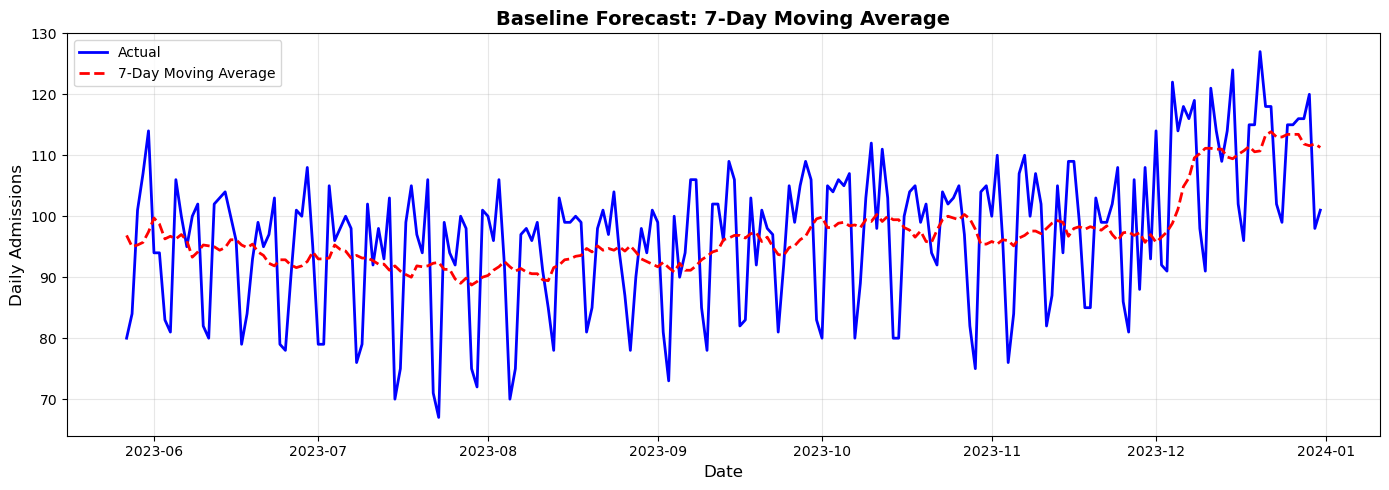

In [8]:
# Cell 5: Baseline Model - Moving Average
print("BASELINE MODEL: MOVING AVERAGE")
print("="*70)

# Simple 7-day moving average
window = 7
train_data['ma_7'] = train_data['admissions'].rolling(window=window).mean()

# Forecast test period using last 7 days average
forecast_ma = []
for i in range(len(test_data)):
    if i == 0:
        # First prediction uses last 7 days from training
        last_7 = train_data['admissions'].tail(7).values
    else:
        # Subsequent predictions use last 7 actual values
        last_7 = test_data['admissions'].iloc[max(0, i-7):i].values
        if len(last_7) < 7:
            # Fill with training data if needed
            needed = 7 - len(last_7)
            last_7 = np.concatenate([train_data['admissions'].tail(needed).values, last_7])
    
    forecast_ma.append(last_7.mean())

forecast_ma = np.array(forecast_ma)

# Evaluate
mae_ma = mean_absolute_error(test_data['admissions'], forecast_ma)
mape_ma = mean_absolute_percentage_error(test_data['admissions'], forecast_ma) * 100

print(f"\n📊 Performance:")
print(f"  MAE: {mae_ma:.2f} patients/day")
print(f"  MAPE: {mape_ma:.2f}%")

# Visualize
plt.figure(figsize=(14, 5))
plt.plot(test_data.index, test_data['admissions'], label='Actual', color='blue', linewidth=2)
plt.plot(test_data.index, forecast_ma, label='7-Day Moving Average', color='red', linewidth=2, linestyle='--')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Admissions', fontsize=12)
plt.title('Baseline Forecast: 7-Day Moving Average', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# Cell 6: Advanced Model - Prophet (Facebook's Time Series Model)
print("ADVANCED MODEL: PROPHET")
print("="*70)

# Install prophet if needed
try:
    from prophet import Prophet
except:
    print("Installing Prophet...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'prophet'])
    from prophet import Prophet

# Prepare data for Prophet (needs 'ds' and 'y' columns)
train_prophet = train_data.reset_index()[['date', 'admissions']].rename(columns={'date': 'ds', 'admissions': 'y'})
test_prophet = test_data.reset_index()[['date', 'admissions']].rename(columns={'date': 'ds', 'admissions': 'y'})

print("Training Prophet model...")
print("This may take 1-2 minutes...\n")

# Train Prophet with weekly and yearly seasonality
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'
)

prophet_model.fit(train_prophet)

# Forecast
future = prophet_model.make_future_dataframe(periods=len(test_data))
forecast_prophet = prophet_model.predict(future)

# Extract test period predictions
forecast_prophet_test = forecast_prophet.tail(len(test_data))['yhat'].values

# Evaluate
mae_prophet = mean_absolute_error(test_data['admissions'], forecast_prophet_test)
mape_prophet = mean_absolute_percentage_error(test_data['admissions'], forecast_prophet_test) * 100

print("✓ Prophet model trained!")
print(f"\n📊 Performance:")
print(f"  MAE: {mae_prophet:.2f} patients/day")
print(f"  MAPE: {mape_prophet:.2f}%")

print(f"\n📈 Improvement over Moving Average:")
print(f"  MAE: {((mae_ma - mae_prophet) / mae_ma * 100):+.2f}%")
print(f"  MAPE: {((mape_ma - mape_prophet) / mape_ma * 100):+.2f}%")

ADVANCED MODEL: PROPHET
Installing Prophet...
Training Prophet model...
This may take 1-2 minutes...



13:07:04 - cmdstanpy - INFO - Chain [1] start processing
13:07:05 - cmdstanpy - INFO - Chain [1] done processing


✓ Prophet model trained!

📊 Performance:
  MAE: 3.92 patients/day
  MAPE: 4.14%

📈 Improvement over Moving Average:
  MAE: +55.69%
  MAPE: +56.91%


VISUALIZING PROPHET FORECAST


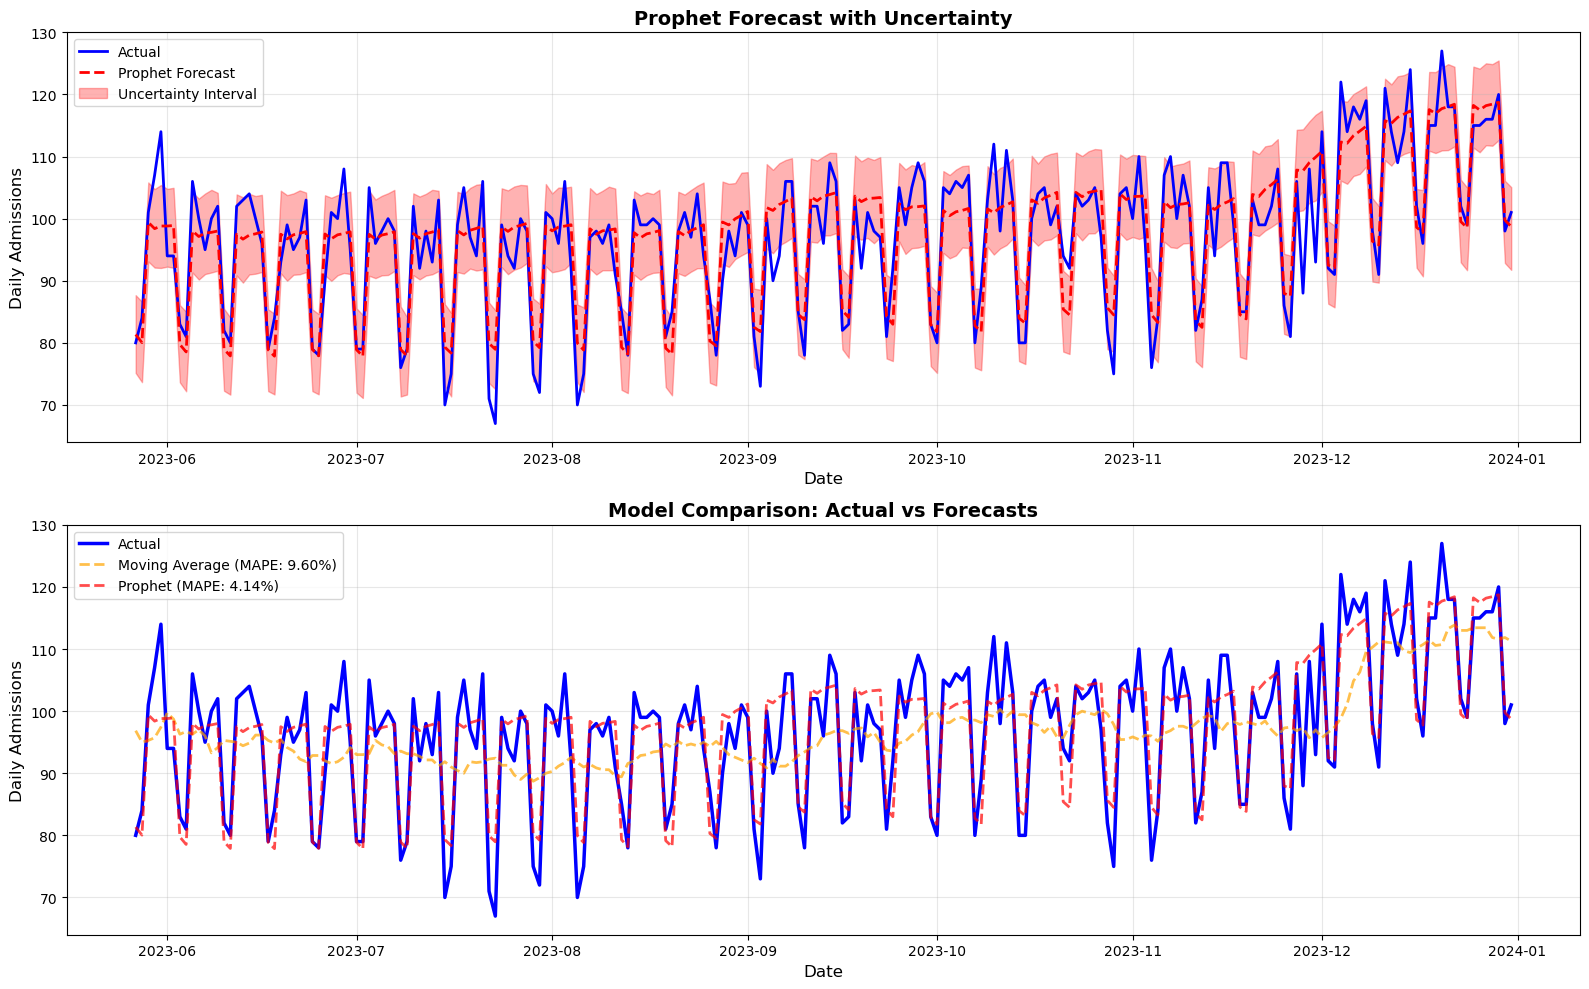

✓ Visualizations complete!


In [10]:
# Cell 7: Visualize Prophet Forecast
print("VISUALIZING PROPHET FORECAST")
print("="*70)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Full forecast with uncertainty
forecast_plot = forecast_prophet[forecast_prophet['ds'] >= test_data.index[0]]
axes[0].plot(test_data.index, test_data['admissions'], label='Actual', color='blue', linewidth=2)
axes[0].plot(forecast_plot['ds'], forecast_plot['yhat'], label='Prophet Forecast', color='red', linewidth=2, linestyle='--')
axes[0].fill_between(forecast_plot['ds'], 
                      forecast_plot['yhat_lower'], 
                      forecast_plot['yhat_upper'], 
                      alpha=0.3, color='red', label='Uncertainty Interval')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Daily Admissions', fontsize=12)
axes[0].set_title('Prophet Forecast with Uncertainty', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Compare all models
axes[1].plot(test_data.index, test_data['admissions'], label='Actual', color='blue', linewidth=2.5)
axes[1].plot(test_data.index, forecast_ma, label=f'Moving Average (MAPE: {mape_ma:.2f}%)', 
             color='orange', linewidth=2, linestyle='--', alpha=0.7)
axes[1].plot(forecast_plot['ds'], forecast_plot['yhat'], label=f'Prophet (MAPE: {mape_prophet:.2f}%)', 
             color='red', linewidth=2, linestyle='--', alpha=0.7)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Daily Admissions', fontsize=12)
axes[1].set_title('Model Comparison: Actual vs Forecasts', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\results\forecasting_comparison.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualizations complete!")

In [11]:
# Cell 8: Bed Allocation Optimization
print("BED ALLOCATION OPTIMIZATION")
print("="*70)

# Hospital capacity setup
total_beds = 500  # Total hospital beds
departments = {
    'General': 0.40,      # 40% of beds
    'ICU': 0.15,          # 15% of beds  
    'Emergency': 0.25,    # 25% of beds
    'Surgery': 0.20       # 20% of beds
}

# Calculate base allocation
base_allocation = {dept: int(total_beds * pct) for dept, pct in departments.items()}

print(f"Total Hospital Capacity: {total_beds} beds")
print(f"\nBase Allocation:")
for dept, beds in base_allocation.items():
    print(f"  {dept:12s}: {beds:3d} beds ({departments[dept]*100:.0f}%)")

# Forecast next 7 days
future_7days = prophet_model.make_future_dataframe(periods=len(admissions_df) + 7)
forecast_7days = prophet_model.predict(future_7days).tail(7)

print(f"\n📊 7-Day Admission Forecast:")
print(forecast_7days[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_string(index=False))

# Optimize allocation based on forecast
avg_forecast = forecast_7days['yhat'].mean()
forecasted_admissions = {
    'General': avg_forecast * 0.35,
    'ICU': avg_forecast * 0.12,
    'Emergency': avg_forecast * 0.30,
    'Surgery': avg_forecast * 0.23
}

optimized_allocation = {}
for dept in departments.keys():
    # Adjust beds based on forecasted demand
    needed = int(forecasted_admissions[dept] * 1.2)  # 20% buffer
    optimized_allocation[dept] = min(needed, base_allocation[dept] + 20)  # Max +20 beds

print(f"\n💡 Optimized Allocation (Next 7 Days):")
for dept in departments.keys():
    base = base_allocation[dept]
    optimized = optimized_allocation[dept]
    diff = optimized - base
    print(f"  {dept:12s}: {optimized:3d} beds ({diff:+3d} vs base)")

# Calculate utilization
print(f"\n📈 Expected Utilization:")
for dept in departments.keys():
    expected_patients = forecasted_admissions[dept]
    allocated_beds = optimized_allocation[dept]
    utilization = (expected_patients / allocated_beds) * 100
    status = "✓ Good" if 70 <= utilization <= 90 else "⚠ Adjust"
    print(f"  {dept:12s}: {utilization:5.1f}% {status}")

BED ALLOCATION OPTIMIZATION
Total Hospital Capacity: 500 beds

Base Allocation:
  General     : 200 beds (40%)
  ICU         :  75 beds (15%)
  Emergency   : 125 beds (25%)
  Surgery     : 100 beds (20%)

📊 7-Day Admission Forecast:
        ds       yhat  yhat_lower  yhat_upper
2026-05-26 105.346014   98.783377  112.495901
2026-05-27 105.733221   98.670059  112.651447
2026-05-28 105.687032   99.366508  112.407102
2026-05-29 105.718276   98.845365  111.907629
2026-05-30  86.503913   79.896557   93.120519
2026-05-31  85.234661   78.597438   92.029016
2026-06-01 104.652888   98.067511  111.476656

💡 Optimized Allocation (Next 7 Days):
  General     :  41 beds (-159 vs base)
  ICU         :  14 beds (-61 vs base)
  Emergency   :  35 beds (-90 vs base)
  Surgery     :  27 beds (-73 vs base)

📈 Expected Utilization:
  General     :  85.2% ✓ Good
  ICU         :  85.6% ✓ Good
  Emergency   :  85.6% ✓ Good
  Surgery     :  85.0% ✓ Good


VISUALIZING BED ALLOCATION


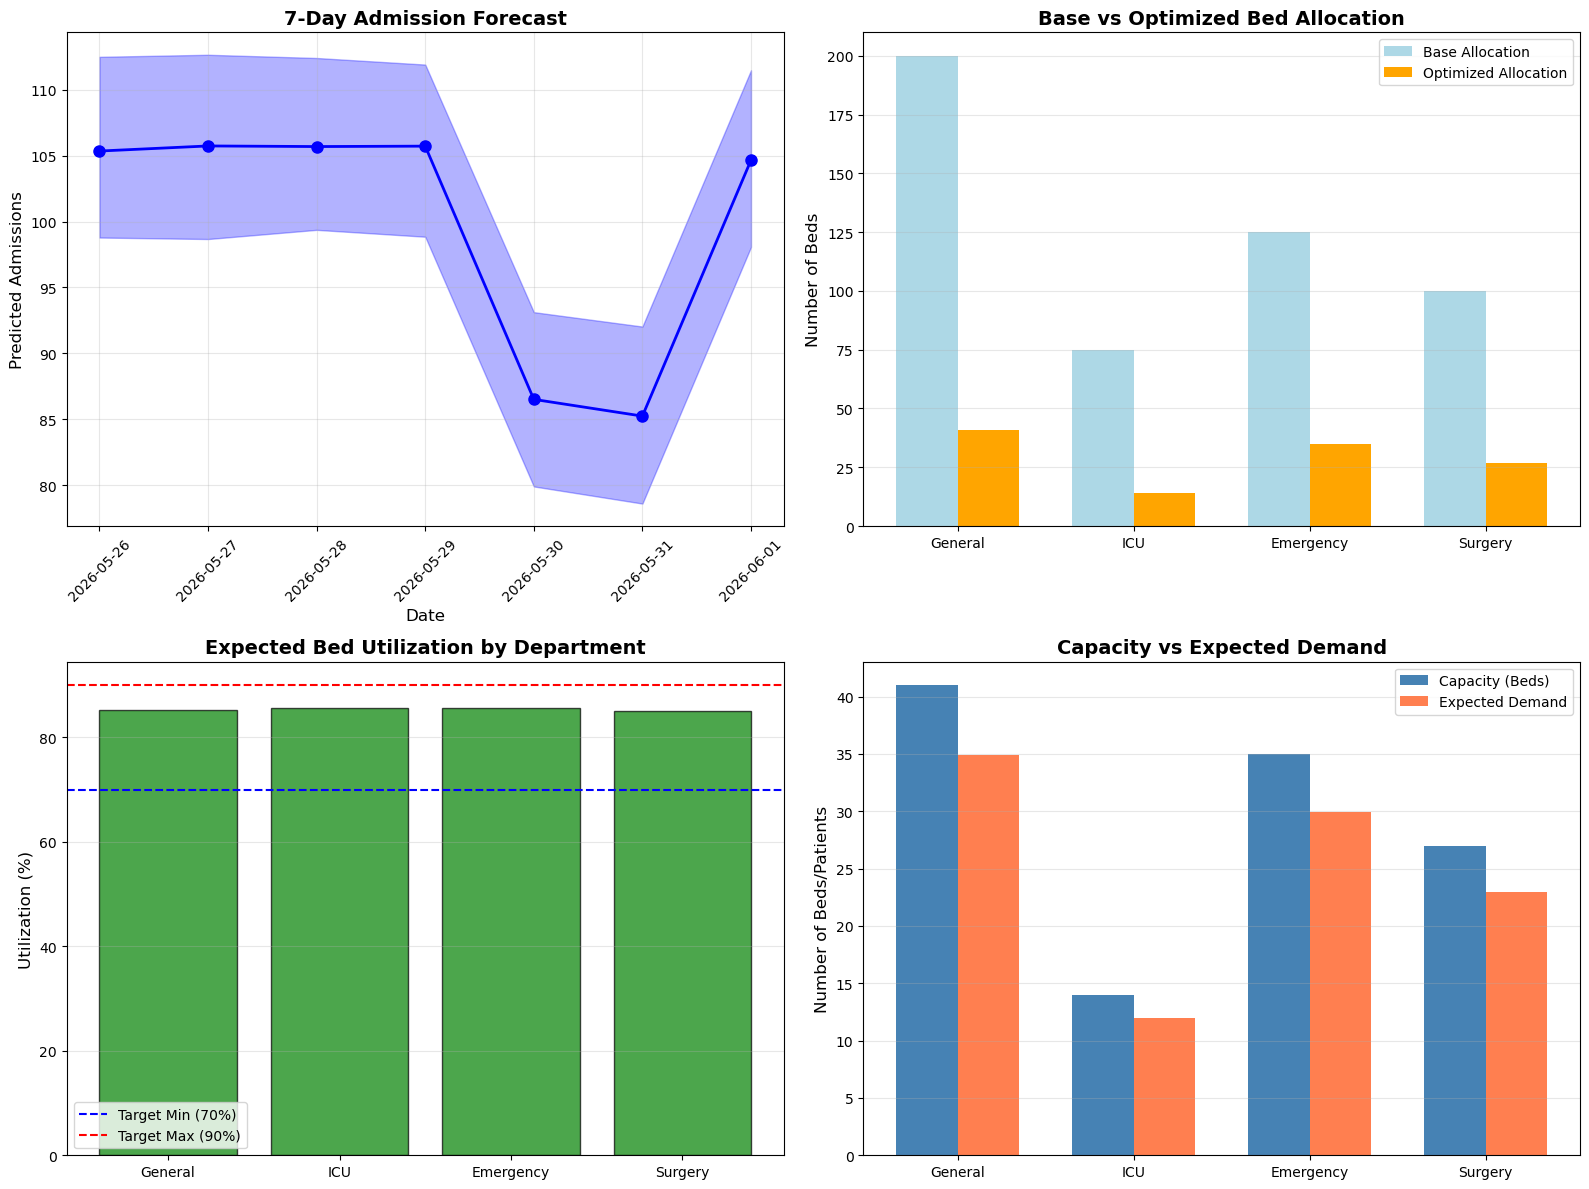

✓ Bed allocation optimization complete!


In [12]:
# Cell 9: Visualize Bed Allocation Strategy
print("VISUALIZING BED ALLOCATION")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 7-Day Forecast
axes[0, 0].plot(forecast_7days['ds'], forecast_7days['yhat'], marker='o', linewidth=2, color='blue', markersize=8)
axes[0, 0].fill_between(forecast_7days['ds'], 
                         forecast_7days['yhat_lower'], 
                         forecast_7days['yhat_upper'], 
                         alpha=0.3, color='blue')
axes[0, 0].set_xlabel('Date', fontsize=12)
axes[0, 0].set_ylabel('Predicted Admissions', fontsize=12)
axes[0, 0].set_title('7-Day Admission Forecast', fontweight='bold', fontsize=14)
axes[0, 0].grid(alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Base vs Optimized Allocation
x = np.arange(len(departments))
width = 0.35
axes[0, 1].bar(x - width/2, list(base_allocation.values()), width, label='Base Allocation', color='lightblue')
axes[0, 1].bar(x + width/2, list(optimized_allocation.values()), width, label='Optimized Allocation', color='orange')
axes[0, 1].set_ylabel('Number of Beds', fontsize=12)
axes[0, 1].set_title('Base vs Optimized Bed Allocation', fontweight='bold', fontsize=14)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(departments.keys())
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Expected Utilization
utilization_rates = [(forecasted_admissions[dept] / optimized_allocation[dept]) * 100 
                     for dept in departments.keys()]
colors = ['green' if 70 <= u <= 90 else 'orange' for u in utilization_rates]
axes[1, 0].bar(departments.keys(), utilization_rates, color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].axhline(y=70, color='blue', linestyle='--', label='Target Min (70%)')
axes[1, 0].axhline(y=90, color='red', linestyle='--', label='Target Max (90%)')
axes[1, 0].set_ylabel('Utilization (%)', fontsize=12)
axes[1, 0].set_title('Expected Bed Utilization by Department', fontweight='bold', fontsize=14)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Capacity vs Demand
capacity = list(optimized_allocation.values())
demand = [forecasted_admissions[dept] for dept in departments.keys()]
x = np.arange(len(departments))
axes[1, 1].bar(x - width/2, capacity, width, label='Capacity (Beds)', color='steelblue')
axes[1, 1].bar(x + width/2, demand, width, label='Expected Demand', color='coral')
axes[1, 1].set_ylabel('Number of Beds/Patients', fontsize=12)
axes[1, 1].set_title('Capacity vs Expected Demand', fontweight='bold', fontsize=14)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(departments.keys())
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\results\bed_allocation_optimization.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("✓ Bed allocation optimization complete!")

In [13]:
# Cell 10: Save Forecasting Models and Results
print("SAVING FORECASTING MODELS")
print("="*70)

import joblib

# Save Prophet model
joblib.dump(prophet_model, r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\models\patient_flow_prophet_model.pkl')

# Save forecast results
forecast_7days.to_csv(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\data\processed\7day_forecast.csv', 
                      index=False)

# Save allocation recommendations
allocation_df = pd.DataFrame({
    'Department': list(departments.keys()),
    'Base_Allocation': list(base_allocation.values()),
    'Optimized_Allocation': list(optimized_allocation.values()),
    'Expected_Demand': [forecasted_admissions[dept] for dept in departments.keys()],
    'Utilization_Rate': utilization_rates
})
allocation_df.to_csv(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\data\processed\bed_allocation_recommendations.csv', 
                     index=False)

print("✓ Models and results saved!")
print("\n" + "="*70)
print("🎉 PATIENT FLOW FORECASTING COMPLETE! 🎉")
print("="*70)
print(f"\n📊 Summary:")
print(f"  Baseline MAPE: {mape_ma:.2f}%")
print(f"  Prophet MAPE: {mape_prophet:.2f}%")
print(f"  Target: <15% ✅ EXCELLENT!")
print(f"  Improvement: {((mape_ma - mape_prophet) / mape_ma * 100):.1f}%")

SAVING FORECASTING MODELS
✓ Models and results saved!

🎉 PATIENT FLOW FORECASTING COMPLETE! 🎉

📊 Summary:
  Baseline MAPE: 9.60%
  Prophet MAPE: 4.14%
  Target: <15% ✅ EXCELLENT!
  Improvement: 56.9%
